In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Homework: scikit-image

## Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

/Users/samdixon/miniconda/envs/seminar-env/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


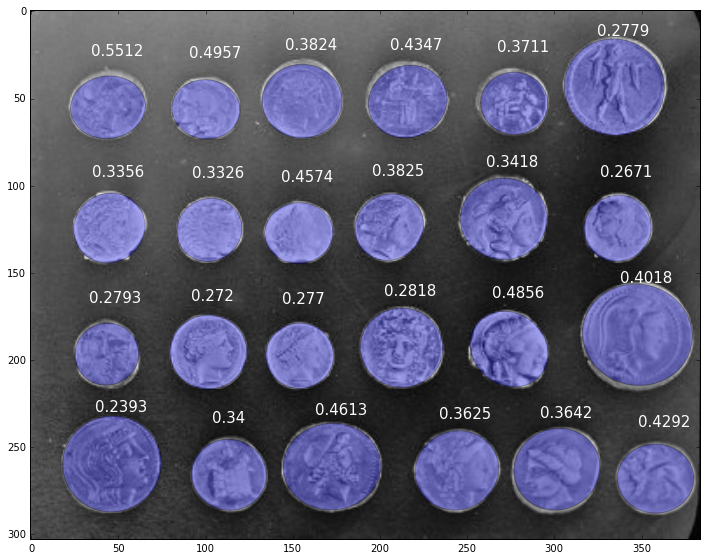

In [162]:
from skimage import img_as_float
from skimage.data import coins
from skimage.exposure import equalize_adapthist
from skimage.filters import rank, gaussian
from skimage.segmentation import clear_border
from skimage.morphology import closing, disk, reconstruction
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from matplotlib.patches import Ellipse
img = img_as_float(coins())
plt.figure(figsize=(12,10))
plt.imshow(img, cmap='gray')
img = gaussian(img, 1)
seed = np.copy(img)
seed[1:-1, 1:-1] = img.min()
dilated = reconstruction(seed, img, method='dilation')
img = img-dilated
img = equalize_adapthist(img)
thresh = threshold_otsu(img)
img = closing(img > thresh, disk(3))
labels = label(img)
for region in regionprops(labels):
    if region.area<100:
        continue
    e = Ellipse(xy=region.centroid[::-1], 
                width=region.major_axis_length, 
                height=region.minor_axis_length, 
                angle=-region.orientation*180/np.pi)
    ax = plt.gca()
    ax.add_artist(e)
    e.set_alpha(0.3)
    ax.annotate('{0:.4}'.format(region.eccentricity), 
                xy=region.centroid[::-1], 
                xytext=np.array(region.centroid[::-1])+[-10, -30],
                fontsize=15,
                color='white')

## Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

In [229]:
from skimage.io import ImageCollection

imgs = ImageCollection('./JDW_*.jpg')
imgs = [rgb2gray(img) for img in imgs]

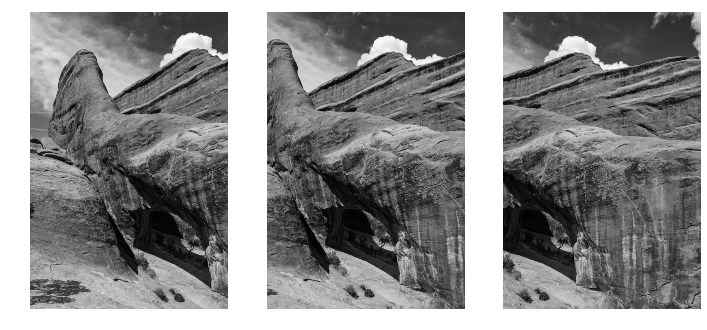

In [231]:
plt.figure(figsize=(12, 8))
for i, img in enumerate(imgs):
    plt.subplot(1, len(imgs), i+1)
    plt.imshow(img, cmap='gray')
    plt.gca().axis('off')

In [233]:
from skimage.feature import ORB, match_descriptors

orb = ORB(n_keypoints=800, fast_threshold=0.05)
keypoints, descriptors = [], []
for img in imgs:
    orb.detect_and_extract(img)
    keypoints.append(orb.keypoints)
    descriptors.append(orb.descriptors)

In [234]:
matches = []
target_index = 1
for i, img in enumerate(imgs):
    if i==target_index:
        matches.append(None)
    else:
        matches.append(match_descriptors(descriptors[i], descriptors[target_index], cross_check=True))

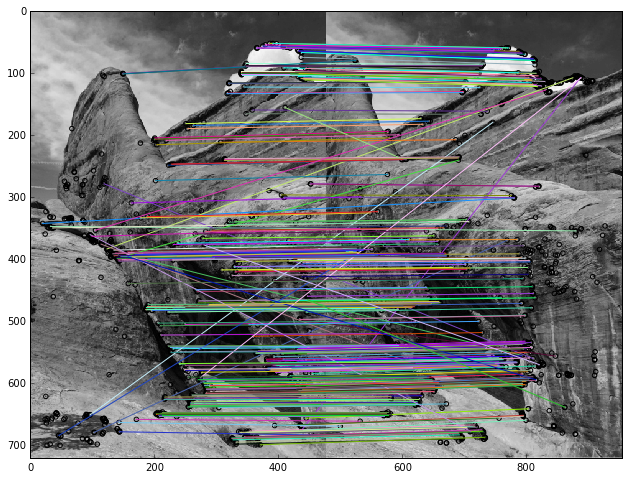

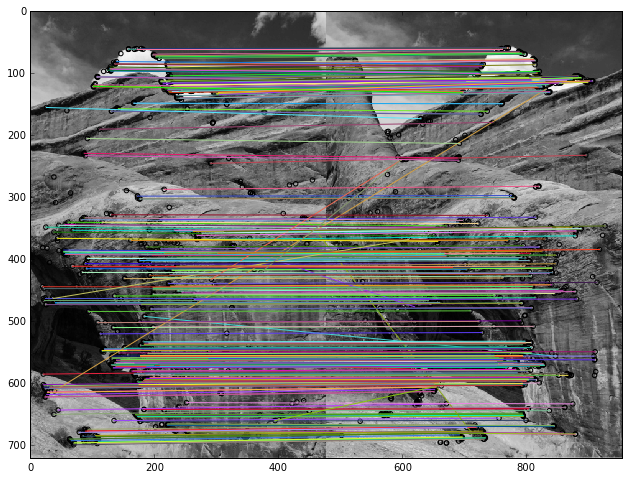

In [235]:
from skimage.feature import plot_matches
for i, img in enumerate(imgs):
    plt.figure(figsize=(12, 8))
    if i != target_index:
        plt.imshow(rgb2gray(img), cmap='gray')
        plot_matches(plt.gca(), img, imgs[target_index], keypoints[i], keypoints[target_index], matches[i])
        ax.axis('off')
        plt.show();

In [236]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

robust_models, inliers = [], []
for i, img in enumerate(imgs):
    if i != target_index:
        src = keypoints[i][matches[i][:, 0]][:, ::-1]
        dst = keypoints[target_index][matches[i][:, 1]][:, ::-1]
        model_robust, inlier = ransac((src, dst), ProjectiveTransform,
                                       min_samples=4, residual_threshold=1, max_trials=300)
        robust_models.append(model_robust)
        inliers.append(inlier)
    else:
        robust_models.append(None)
        inliers.append(None)

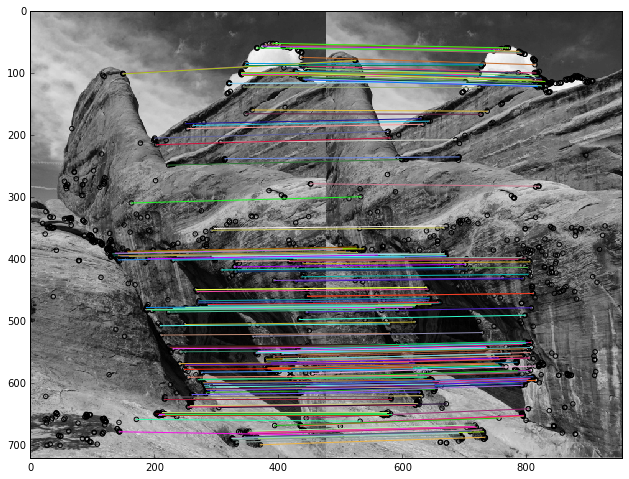

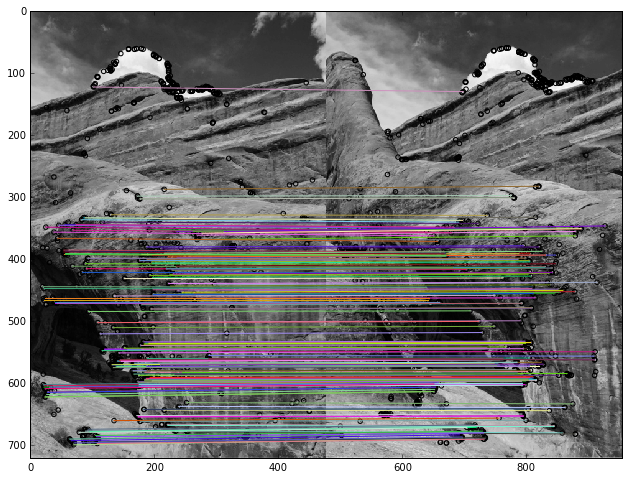

In [237]:
for i, img in enumerate(imgs):
    plt.figure(figsize=(12, 8))
    if i != target_index:
        plt.imshow(rgb2gray(img), cmap='gray')
        plot_matches(plt.gca(), img, imgs[target_index], keypoints[i], keypoints[target_index], matches[i][inliers[i]])
        ax.axis('off')
        plt.show();

In [238]:
from skimage.transform import SimilarityTransform

r, c = imgs[target_index].shape[:2]
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])
all_corners = []
for i, img in enumerate(imgs):
    if i != target_index:
        all_corners.append(robust_models[i](corners))
    else:
        all_corners.append(corners)
all_corners = np.vstack(all_corners)

corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

output_shape = np.ceil(output_shape[::-1]).astype(int)      

In [239]:
from skimage.transform import warp

offset_target = SimilarityTransform(translation=-corner_min)
warp_target = warp(imgs[target_index], offset_target.inverse, order=3,
                    output_shape=output_shape, cval=-1)

target_mask = (warp_target != -1)  # Mask == 1 inside image
warp_target[~target_mask] = 0 

In [240]:
warped_imgs, masks = [], []
for i, img in enumerate(imgs):
    if i != target_index:
        transform = (robust_models[i] + offset_target).inverse
        warped = warp(img, transform, order=3,
                    output_shape=output_shape, cval=-1)
        mask = (warped != -1)  # Mask == 1 inside image
        warped[~mask] = 0 
        warped_imgs.append(warped)
        masks.append(mask)
    else:
        masks.append(target_mask)
        warped_imgs.append(warp_target)

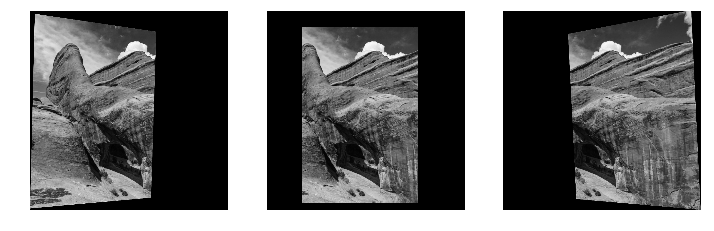

In [242]:
plt.figure(figsize=(12, 8))
for i, img in enumerate(warped_imgs):
    plt.subplot(1, len(imgs), i+1)
    plt.imshow(img, cmap='gray')
    plt.gca().axis('off')

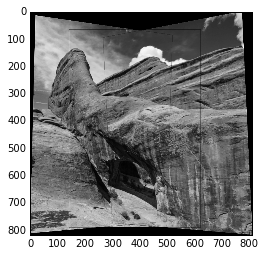

In [243]:
merged = sum(warped_imgs)
overlap = sum(masks)
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized, cmap='gray')

In [244]:
ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

# Start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    ymax // 3],
              [xmax, ymax // 3]]

# Start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*ymax // 3],
              [xmax, 2*ymax // 3]]

In [247]:
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

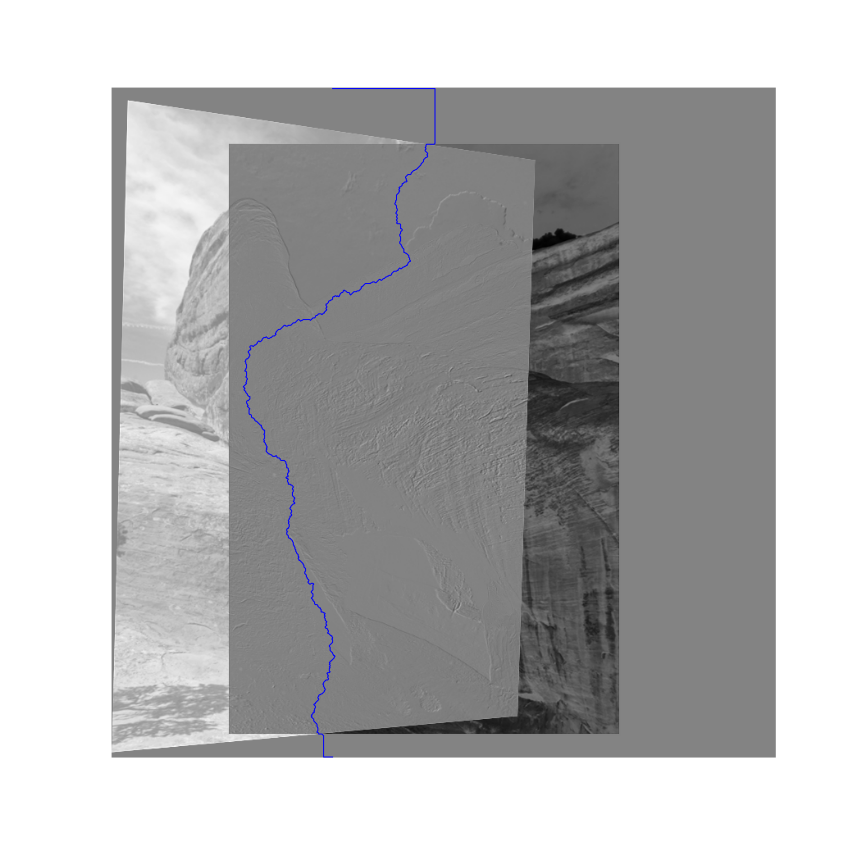

In [259]:
from skimage.graph import route_through_array

costs01 = generate_costs(np.abs(warped_imgs[0] - warped_imgs[1]),
                         masks[0] & masks[1])
costs01[0,  :] = 0
costs01[-1, :] = 0

pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)
pts = np.array(pts)

ig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(warped_imgs[0] - warped_imgs[1], cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0])  

plt.tight_layout()
ax.axis('off');

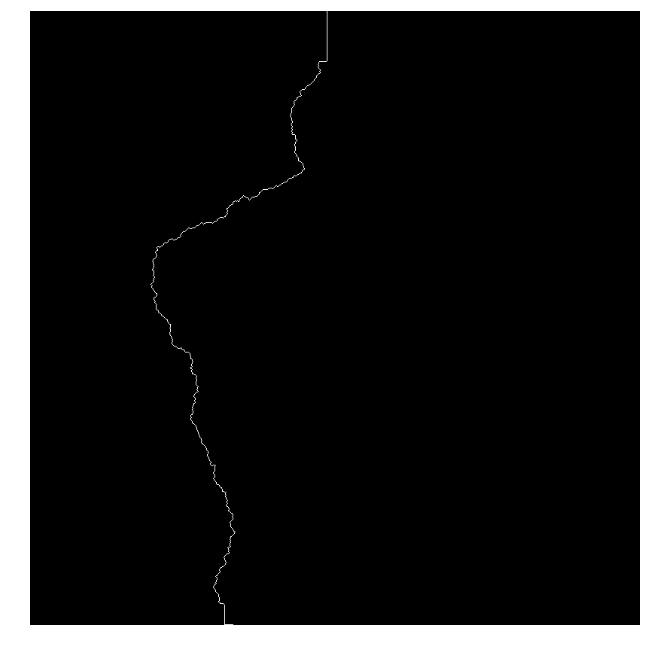

In [260]:
masks[0] = np.zeros_like(warped_imgs[0], dtype=np.uint8)
masks[0][pts[:, 0], pts[:, 1]] = 1
fig, ax = plt.subplots(figsize=(11, 11))
ax.imshow(masks[0], cmap='gray')
ax.axis('off');

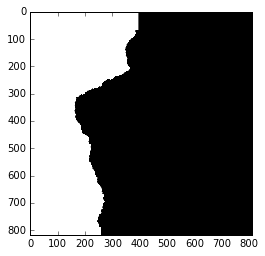

In [261]:
from skimage.measure import label

# Labeling starts with one at point (0, 0)
masks[0] = (label(masks[0], connectivity=1, background=-1) == 1)

# The result
plt.imshow(masks[0], cmap='gray');

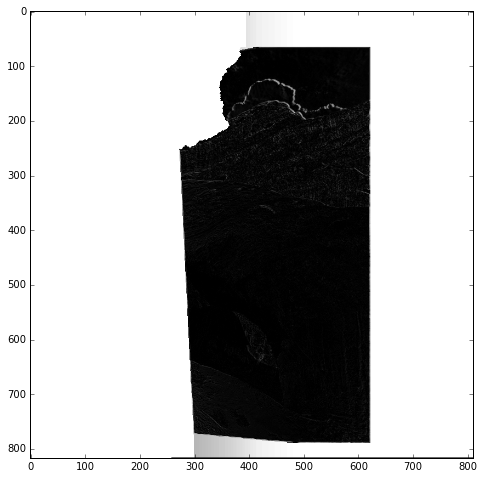

In [262]:
# Start with the absolute value of the difference image.
# np.abs necessary because we don't want negative costs!
costs12 = generate_costs(np.abs(warped_imgs[1] - warped_imgs[2]),
                         masks[1] & masks[2])

# Allow the path to "slide" along top and bottom edges to the optimal 
# horizontal position by setting top and bottom edges to zero cost
costs12[0,  :] = 0
costs12[-1, :] = 0
costs12[masks[0] > 0] = 1

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(costs12, cmap='gray');

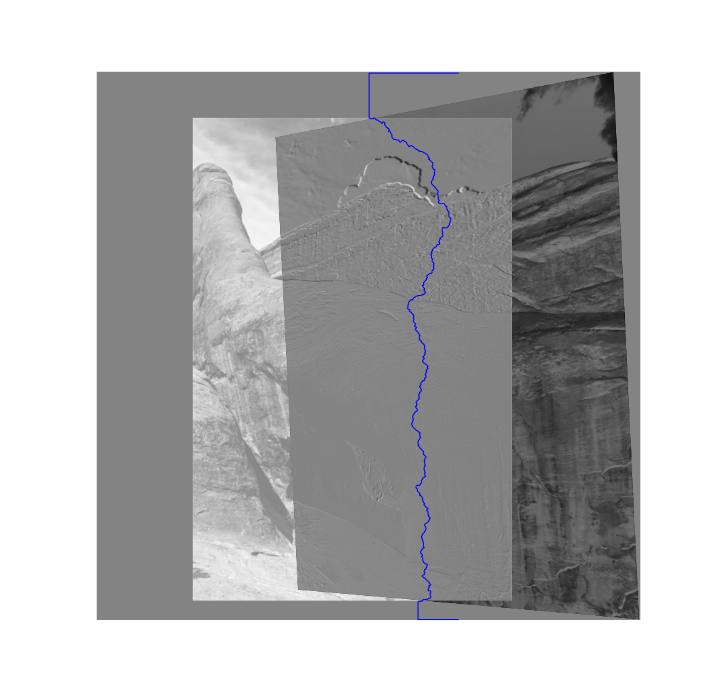

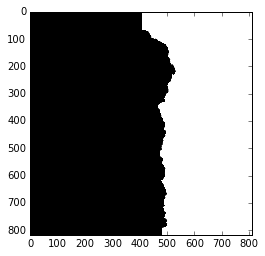

In [263]:
pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)
pts = np.array(pts)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(warped_imgs[1] - warped_imgs[2], cmap='gray')
ax.plot(pts[:, 1], pts[:, 0]);
ax.axis('off');
plt.show();
masks[2] = np.zeros_like(warped_imgs[0], dtype=np.uint8)
masks[2][pts[:, 0], pts[:, 1]] = 1
masks[2] = (label(masks[2], connectivity=1, background=-1) == 3)
plt.imshow(masks[2], cmap='gray');

In [264]:
masks[1] = ~(masks[0] | masks[2]).astype(bool)

In [265]:
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

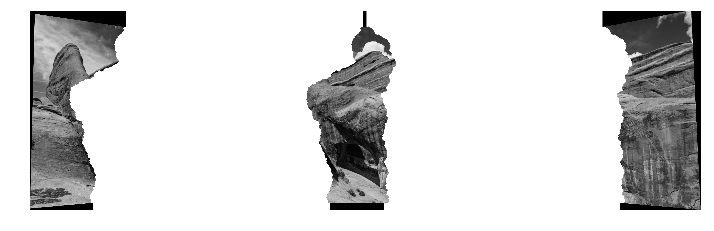

In [267]:
plt.figure(figsize=(12, 12))
for i, img in enumerate(warped_imgs):
    final = add_alpha(img, masks[i])
    plt.subplot(1, len(imgs), i+1)
    plt.imshow(final, cmap='gray')
    plt.gca().axis('off')

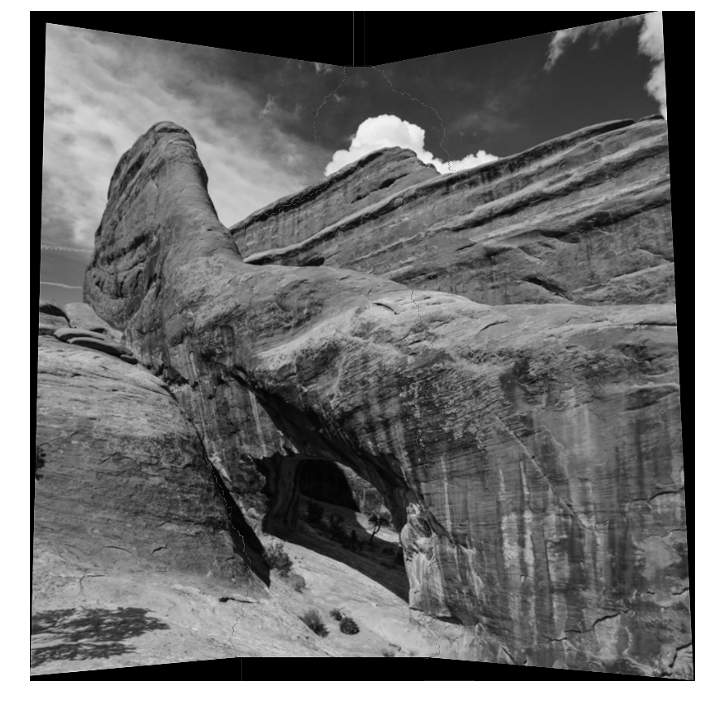

In [268]:
plt.figure(figsize=(12, 12))
for i, img in enumerate(warped_imgs):
    final = add_alpha(img, masks[i])
    plt.imshow(final, cmap='gray')
    plt.gca().axis('off')

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.

In [302]:
from rawpy import imread
import os
from skimage.io import imsave
dark_paths = [os.path.join('./M42_11_16_2012/Darks/', f) for f in os.listdir('./M42_11_16_2012/Darks/')]
flat_paths = [os.path.join('./M42_11_16_2012/Flats/', f) for f in os.listdir('./M42_11_16_2012/Flats/')]
sci_paths = [os.path.join('./M42_11_16_2012/Lights/', f) for f in os.listdir('./M42_11_16_2012/Lights/')]
for p in sci_paths:
    out_path = '/'.join(p.split('/')[:-1])+'/'+os.path.basename(p).split('.')[0]+'.tiff'
    raw = imread(p)
    img = raw.postprocess()
    imsave(out_path, img)
for p in flat_paths:
    out_path = '/'.join(p.split('/')[:-1])+'/'+os.path.basename(p).split('.')[0]+'.tiff'
    raw = imread(p)
    img = raw.postprocess()
    imsave(out_path, img)
for p in dark_paths:
    out_path = '/'.join(p.split('/')[:-1])+'/'+os.path.basename(p).split('.')[0]+'.tiff'
    raw = imread(p)
    img = raw.postprocess()
    imsave(out_path, img)

In [10]:
from skimage.io import ImageCollection

darks = ImageCollection('./M42_11_16_2012/Darks/*.tiff', as_grey=True)
flats = ImageCollection('./M42_11_16_2012/Flats/*.tiff', as_grey=True)
sci = ImageCollection('./M42_11_16_2012/Lights/*.tiff', as_grey=True)

## Master dark

In [4]:
dark_stack = np.array([d for d in darks[:5]])

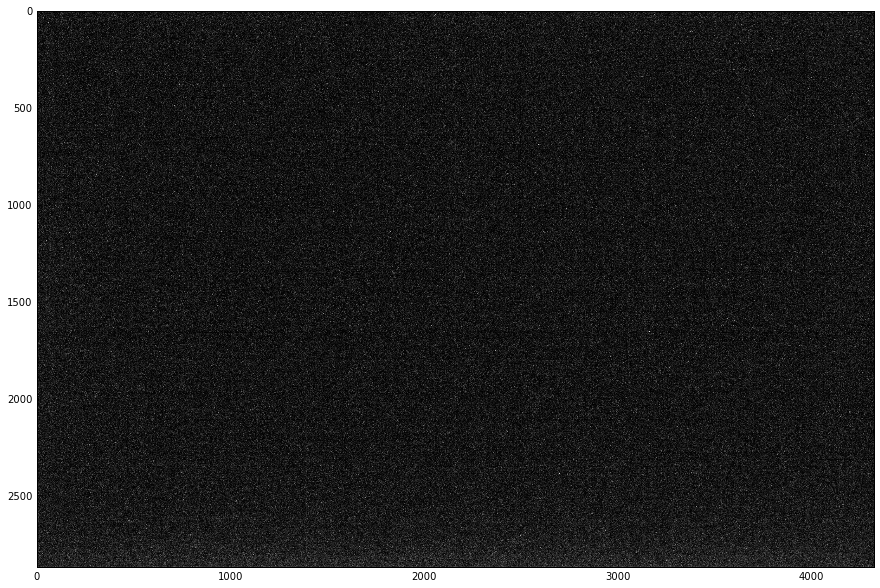

In [5]:
plt.figure(figsize=(15, 10))
master_dark = np.median(dark_stack, axis=0)
plt.imshow(master_dark, cmap='gray')

## Master flat

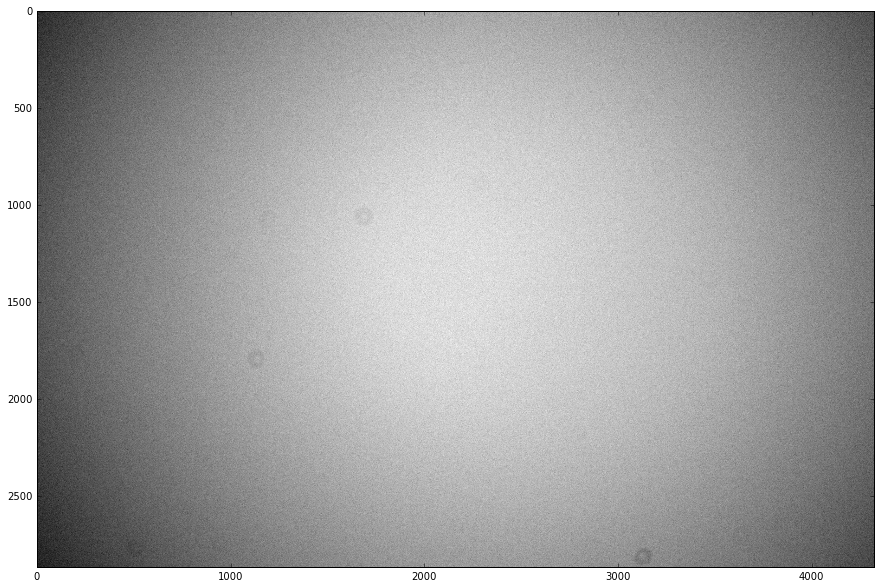

In [6]:
flat_stack = np.array([f for f in flats[:5]])
master_flat = np.median(flat_stack, axis=0)
plt.figure(figsize=(15, 10))
plt.imshow(master_flat, cmap='gray')

## Stack dark subtracted and flatfield divided images

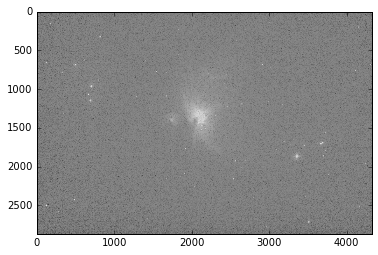

In [15]:
final = np.zeros_like(sci[0])
for img in sci:
    img -= master_dark
    img /= master_flat
    final += img
plt.imshow(final, cmap='gray')

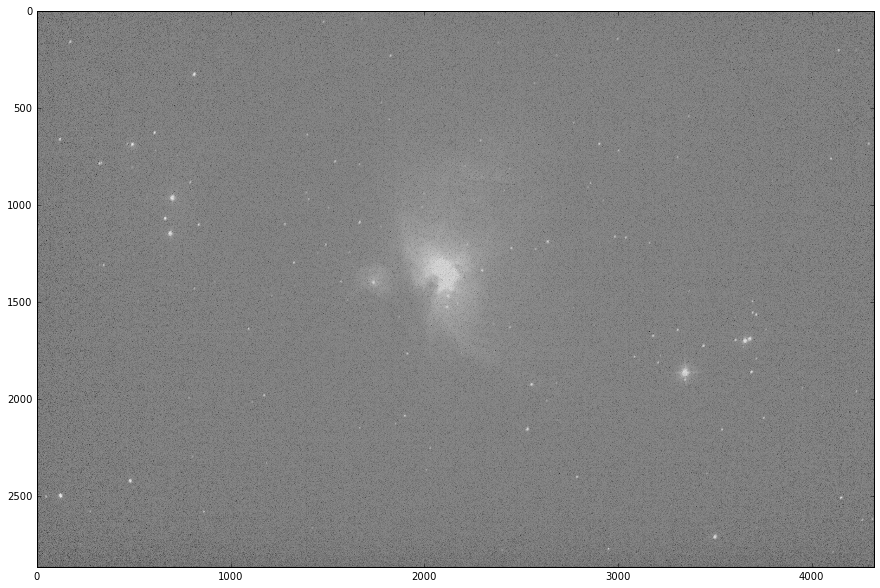

In [18]:
plt.figure(figsize=(15, 12))
plt.imshow(final, cmap='gray')